In [1]:
import random
import time
import string

def generate_image_name(extension="png"):
    # Get the current timestamp
    timestamp = int(time.time())
    
    # Generate a random string of 6 characters
    random_str = ''.join(random.choices(
        string.ascii_lowercase + string.digits, k=6))
    
    # Combine timestamp and random string to create the image name
    image_name = f"image_{timestamp}_{random_str}.{extension}"
    
    return image_name

2024-10-08 21:16:57.490351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 21:16:57.512067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 21:16:57.518640: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 21:16:57.534486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-08 21:16:58.736271: W tensorflow/compiler/tf2

Detected person with confidence 0.999 at location [536.19, 456.76, 582.3, 553.48]


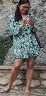

Detected person with confidence 0.998 at location [149.03, 426.33, 181.66, 475.19]


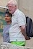

Detected person with confidence 0.998 at location [227.25, 431.66, 252.95, 481.1]


Detected person with confidence 0.999 at location [260.39, 391.95, 353.32, 798.22]


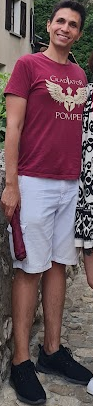

Detected person with confidence 0.999 at location [333.36, 408.59, 428.15, 790.54]


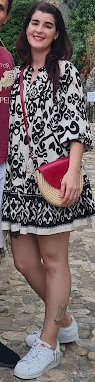

In [2]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image, ImageDraw
import requests
import os

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the selected device

# Define the path where the fashion dataset is stored
FASHION_DATASET_HOME = '/home/jcaldeira/dressing_virtuel_data_collector/media/images/'
__temp_dir = '/home/jcaldeira/dressing_virtuel_data_collector/media/tmp/'
img = '20240706_174232.jpg'

with open(FASHION_DATASET_HOME + img,'rb') as path:
    image = Image.open(path)

    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    # let's only keep detections with score > 0.9
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

    # Draw the bounding boxes on the image
    draw = ImageDraw.Draw(image)

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if model.config.id2label[label.item()] != 'person':
            continue
        box = [round(i, 2) for i in box.tolist()]
        print(
                f"Detected {model.config.id2label[label.item()]} with confidence "
                f"{round(score.item(), 3)} at location {box}"
        )

        cropped_image = image.crop(box)
        cropped_image.show()
        cropped_image_path = os.path.join(__temp_dir, 
                                generate_image_name())
        cropped_image.save(cropped_image_path)
    

<class 'numpy.ndarray'>
It's a picture of me!


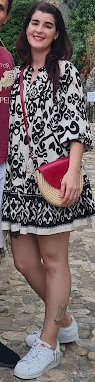

I wasn't able to locate any faces in at least one of the images. Check the image files. Aborting...
I wasn't able to locate any faces in at least one of the images. Check the image files. Aborting...
I wasn't able to locate any faces in at least one of the images. Check the image files. Aborting...
<class 'numpy.ndarray'>
It's not a picture of me!
I wasn't able to locate any faces in at least one of the images. Check the image files. Aborting...
I wasn't able to locate any faces in at least one of the images. Check the image files. Aborting...
I wasn't able to locate any faces in at least one of the images. Check the image files. Aborting...
<class 'numpy.ndarray'>
It's a picture of me!


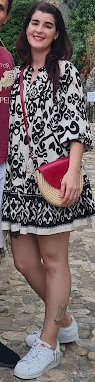

<class 'numpy.ndarray'>
It's not a picture of me!


In [3]:
import face_recognition

face_to_find = FASHION_DATASET_HOME + "/brii/brii.jpg"
list_images = os.listdir(__temp_dir)

picture_of_me = face_recognition.load_image_file(face_to_find)
my_face_encoding = face_recognition.face_encodings(picture_of_me)[0]

# my_face_encoding now contains a universal 'encoding' of my facial features that can be compared to any other picture of a face!

for image in list_images:
    try:
        unknown_picture = face_recognition.load_image_file(__temp_dir + image)
        unknown_face_encoding = face_recognition.face_encodings(unknown_picture)[0]

        # Now we can see the two face encodings are of the same person with `compare_faces`!
        print(type(my_face_encoding))
        results = face_recognition.compare_faces(unknown_face_encoding,[my_face_encoding])
        if results[0] == True:
            print("It's a picture of me!")
            with open(__temp_dir+image, 'rb') as img:
                Image.open(img).show()
        else:
            print("It's not a picture of me!")
    except IndexError:
        print("I wasn't able to locate any faces in at least one of the images. Check the image files. Aborting...")
        continue
